# Kitchen20: an extention to ESC50


The Kitchen20 dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short kitchen sounds recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through bothe the Freesound.org project and diverse participant that agreed on recording specific sounds in their own kitchens.

- Kitchen20: a sound dataset with 800 environmental sounds (20 classes, 40 clips per class)
- ESC70: The concatenation of both ESC50 and Kitchen20

---

The goal of this project is to include specific sounds that would happen in a kitchen to a raw audio dataset of environmental sounds.

This notebook provides a glipse into data.

## Loading the Data:

In [28]:
import os
import shutil
import urllib
import zipfile
import glob
import pandas as pd
import numpy as np
import kitchen20
import kitchen20.kitchen20

dataset = kitchen20.kitchen20.Kitchen20(folds=[1,2,3,4,5],
                                        compute_features=True,
                                        audio_rate=44100)

In [36]:
df  = pd.DataFrame()

for idx in range(len(dataset.labels)):
    
    row = pd.DataFrame([idx], columns=['idx'])
    row['fold'] = dataset.folds_nb[idx]
    row['category'] = dataset.labels[idx]

    # Compute mean and std of the banks in mfcc
    mfcc = dataset.mfcc[idx][:, :]
    mfcc_mean = pd.DataFrame(np.mean(dataset.mfcc[idx][:, :], axis=0)[1:]).T
    mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
    mfcc_std = pd.DataFrame(np.std(dataset.mfcc[idx][:, :], axis=0)[1:]).T
    mfcc_std.columns = list('MFCC_{} std'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
    row = row.join(mfcc_mean)
    row = row.join(mfcc_std)

    # Compute mean and std of zcr
    zcr = dataset.zcr[idx]
    row['ZCR mean'] = np.mean(zcr)
    row['ZCR std'] = np.std(zcr)

    df = df.append(row)

In [76]:
import sklearn as sk
import sklearn.ensemble

df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
features_start = 'MFCC_1 mean'
features_end = 'ZCR std'

confusion = {}

for fold in range(1, 6):
    fold_name = 'f{}'.format(fold)
    train = df[df['fold'] != fold].copy()
    test = df[df['fold'] == fold].copy()

    for i in range(1,13):
        algo_name = 'knn{}'.format(i)
        knn = sk.neighbors.KNeighborsClassifier(n_neighbors=i)
        knn.fit(train.loc[:, features_start:features_end], train['category'])
        test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        df_results.loc[algo_name, fold_name] = accuracy
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        if fold == 1:
            confusion[algo_name] = np.zeros((20, 20), dtype=int)
        confusion[algo_name] = confusion[algo_name] + confusion_current

    algo_name = 'Random Forest'
    rf = sk.ensemble.RandomForestClassifier(n_estimators=500)
    rf.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    df_results.loc[algo_name, fold_name] = accuracy
    confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
    if fold == 1:
        confusion[algo_name] = np.zeros((20, 20), dtype=int)
    confusion[algo_name] = confusion[algo_name] + confusion_current

    algo_name = 'SVM'
    svm = sk.svm.SVC(C=0.1, kernel='linear')
    svm.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    df_results.loc[algo_name, fold_name] = accuracy
    confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
    if fold == 1:
        confusion[algo_name] = np.zeros((20, 20), dtype=int)
    confusion[algo_name] = confusion[algo_name] + confusion_current


In [77]:
df_results['average'] = df_results.mean(axis=1)
df_results

,f1,f2,f3,f4,f5,average
knn1,0.30625,0.3125,0.35,0.375,0.41875,0.35250
knn2,0.28125,0.25625,0.35,0.375,0.41875,0.33625
knn3,0.3125,0.2875,0.34375,0.3625,0.43125,0.34750
knn4,0.3375,0.25625,0.36875,0.375,0.475,0.36250
knn5,0.30625,0.30625,0.33125,0.36875,0.41875,0.34625
knn6,0.29375,0.29375,0.325,0.39375,0.4125,0.34375
knn7,0.3125,0.2875,0.36875,0.35,0.425,0.34875
knn8,0.29375,0.30625,0.35,0.38125,0.41875,0.35000
knn9,0.3125,0.29375,0.3625,0.33125,0.4125,0.34250
knn10,0.2625,0.3,0.35,0.3375,0.40625,0.33125


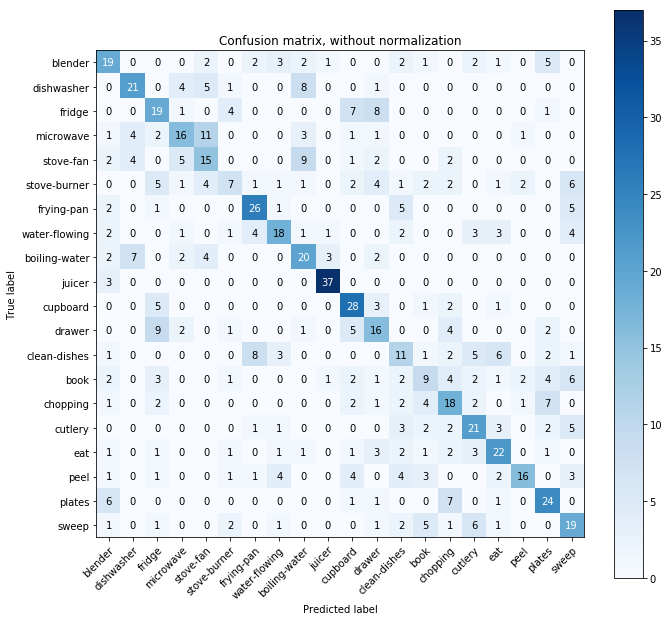

In [78]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(confusion['Random Forest'], dataset.classes) 